In [3]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install git+https://github.com/facebookresearch/detectron2.git

  Using cached PyYAML-5.1.tar.gz (274 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-0m09oavr/pyyaml_cb605029cf684cda9777e77ab5a76292/setup.py", line 291, in <module>
          setup(
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 184, in setup
          return run_commands(dist)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 200, in run_commands
          dist.run_commands()
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/dist.py", line 969, in run_commands
          self.run_command(cmd)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/dist.py

In [4]:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

detectron2 version: 0.6


In [5]:
import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 9
THRESHOLD = 0.3

In [6]:
import json
import copy

# Load the two COCO annotation files
with open('/kaggle/input/bone-fracture-detection-detection-coco-annots/train_annotations.coco.json', 'r') as f:
    coco_big = json.load(f)

with open('/kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json', 'r') as f:
    coco_fracAtlas = json.load(f)

# Paths where images are located for each dataset
big_image_path = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images'
fracAtlas_image_path = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured'

# Create a new dictionary to hold the merged dataset
combined_coco = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 0, "name": "fractured"}],  # Only binary class label
}

# Function to update category ids in annotations to 0 (binary fractured label)
def update_annotations(annotations, image_id_offset, annotation_id_offset):
    updated_annotations = copy.deepcopy(annotations)
    for annotation in updated_annotations:
        annotation["category_id"] = 0  # Set category to binary class "fractured"
        annotation["id"] += annotation_id_offset
        annotation["image_id"] += image_id_offset
    return updated_annotations

# Function to update the image paths for each dataset
def update_image_paths(images, base_path, image_id_offset):
    updated_images = copy.deepcopy(images)
    for image in updated_images:
        image["file_name"] = f"{base_path}/{image['file_name']}"  # Update file path
        image["id"] += image_id_offset  # Update image ID to avoid conflicts
    return updated_images

def add_dummy_annotations(coco_data):
    image_ids_with_annotations = {ann['image_id'] for ann in coco_data['annotations']}
    all_image_ids = {img['id'] for img in coco_data['images']}
    image_ids_without_annotations = all_image_ids - image_ids_with_annotations

    # Create dummy annotations for those images (background, i.e., no object)
    dummy_category_id = 1  # assuming "0" means background or no class
    annotation_id_offset = len(coco_data['annotations'])

    for i, image_id in enumerate(image_ids_without_annotations):
        dummy_annotation = {
            'id': annotation_id_offset + i,
            'image_id': image_id,
            'category_id': dummy_category_id,
            'bbox': [0, 0, 0, 0],  # no object, so an empty bbox
            'area': 0,
            'iscrowd': 0
        }
        coco_data['annotations'].append(dummy_annotation)
    coco_data['categories'].append({"id": 1, "name": "No fracture"})
    return coco_data
    

# Merge images and annotations from the first dataset (coco_big)
image_id_offset = 0
annotation_id_offset = 0
combined_coco["images"].extend(update_image_paths(coco_big["images"], big_image_path, image_id_offset))
combined_coco["annotations"].extend(update_annotations(coco_big["annotations"], image_id_offset, annotation_id_offset))

# Update offsets to avoid conflicts in image and annotation IDs
image_id_offset = len(coco_big["images"])
annotation_id_offset = len(coco_big["annotations"])

# Merge images and annotations from the second dataset (coco_fracAtlas)
combined_coco["images"].extend(update_image_paths(coco_fracAtlas["images"], fracAtlas_image_path, image_id_offset))
combined_coco["annotations"].extend(update_annotations(coco_fracAtlas["annotations"], image_id_offset, annotation_id_offset))

add_dummy_annotations(combined_coco)

# Save the combined dataset as a new JSON file
with open('combined_annotations.coco.json', 'w') as f:
    json.dump(combined_coco, f)

print("Combined COCO dataset with updated image paths created successfully!")

Combined COCO dataset with updated image paths created successfully!


In [7]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

register_coco_instances(f"bone_fractures_big", {},
                            '/kaggle/working/combined_annotations.coco.json',
                            '')

# register_coco_instances(f"bone_fractures_fracAtlas", {},
#                             '/kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json',
#                             '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured')

In [8]:
import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("bone_fractures_big")
train_dataset_dicts = DatasetCatalog.get("bone_fractures_big")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
#     np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]
    
    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        print(img_link)
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()
        
        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

WARNING [10/25 15:27:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/25 15:27:44 d2.data.datasets.coco]: Loaded 4348 images in COCO format from /kaggle/working/combined_annotations.coco.json


/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images/image1_362_png.rf.bb0285de0844c464d55bf25885c95838.jpg
/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured/IMG0002397.jpg
/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images/image1_721_png.rf.3c2ff741dd7ec8e651bd505fc88ef581.jpg
/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images/image1_436_png.rf.02fb0482f3858ace6bc879791ff10206.jpg


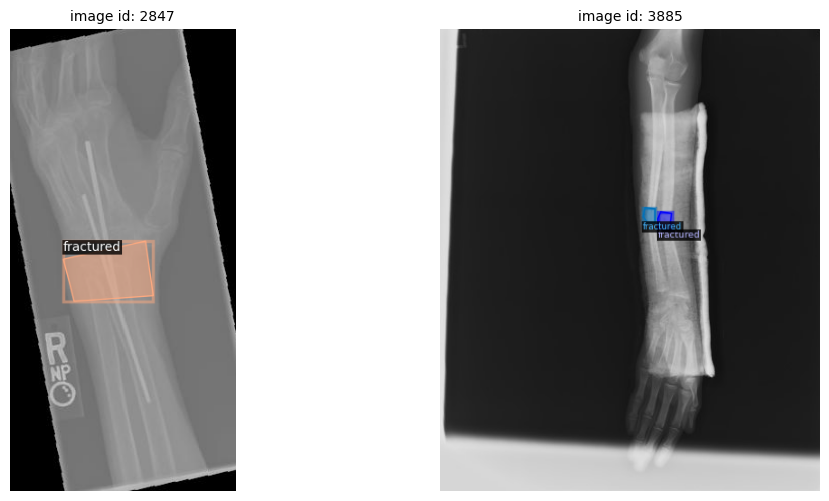

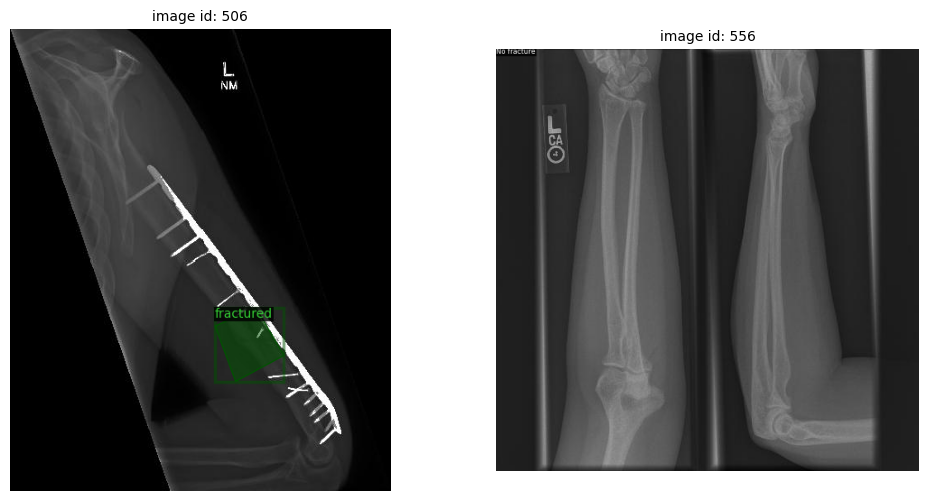

In [9]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 43 , image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 46 , image_scale = 1)

In [10]:
from detectron2.engine import DefaultTrainer

EPOCHS = 1800
NUM_CLASSES = 2
BASE_LR = 0.0005

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bone_fractures_big")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/25 15:27:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:01, 267MB/s]                             


[10/25 15:27:56 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/25 15:28:21 d2.utils.events]:  eta: 0:32:44  iter: 19  total_loss: 1.095  loss_cls: 1.021  loss_box_reg: 0.0001622  loss_rpn_cls: 0.09032  loss_rpn_loc: 0.003859    time: 1.1090  last_time: 1.1613  data_time: 0.0126  last_data_time: 0.0056   lr: 9.9905e-06  max_mem: 5707M
[10/25 15:28:56 d2.utils.events]:  eta: 0:33:02  iter: 39  total_loss: 0.7456  loss_cls: 0.6987  loss_box_reg: 0.0001624  loss_rpn_cls: 0.07824  loss_rpn_loc: 0.006583    time: 1.1165  last_time: 0.7705  data_time: 0.0043  last_data_time: 0.0036   lr: 1.998e-05  max_mem: 5909M
[10/25 15:29:19 d2.utils.events]:  eta: 0:32:39  iter: 59  total_loss: 0.4691  loss_cls: 0.3159  loss_box_reg: 0.0001414  loss_rpn_cls: 0.1083  loss_rpn_loc: 0.005209    time: 1.1223  last_time: 0.9418  data_time: 0.0045  last_data_time: 0.0028   lr: 2.9971e-05  max_mem: 5909M
[10/25 15:29:41 d2.utils.events]:  eta: 0:31:53  iter: 79  total_loss: 0.2988  loss_cls: 0.1465  loss_box_reg: 0.000187  loss_rpn_cls: 0.1253  loss_rpn_loc: 0.01058   

In [18]:
# from detectron2.solver import WarmupCosineLR

# cfg.DATASETS.TRAIN = ("bone_fractures_train",)
# cfg.DATASETS.TEST = ()  # No validation set here, modify if needed
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.WEIGHT_DECAY = 0.0001
# cfg.MODEL.RPN.NMS_THRESH = 0.7
# cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "value"
# cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0
# cfg.SOLVER.BASE_LR = BASE_LR  # Set the base learning rate
# cfg.SOLVER.MAX_ITER = EPOCHS
# cfg.SOLVER.WARMUP_ITERS = int(0.5 * cfg.SOLVER.MAX_ITER)  # Warmup for 10% of total iterations
# cfg.SOLVER.SCHEDULER_NAME = "WarmupCosineLR"  # This applies a cosine decay after warmup

# cfg.SOLVER.MAX_ITER = EPOCHS  # Total iterations for training
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES  

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# # uncomment below to train
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

In [19]:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[10/25 16:00:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

In [20]:
def reading_metrics_from_json(metrics_path):
    metrics = []
    
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [21]:
train_metrics = reading_metrics_from_json('/kaggle/working/output/metrics.json')

total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss))

Text(0.5, 1.0, 'False Negative')

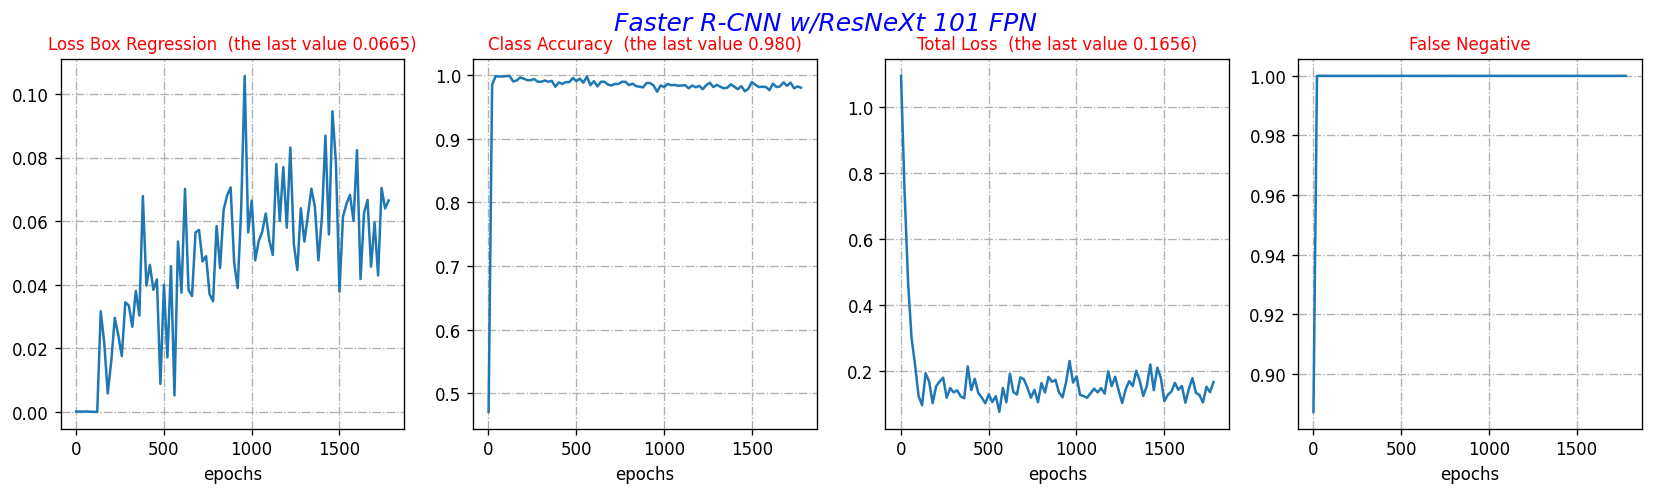

In [22]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)
fig.suptitle('Faster R-CNN w/ResNeXt 101 FPN', color = 'blue', fontsize=15,  style = "italic")

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

In [23]:
register_coco_instances(f"bone_fractures_val", {},
                            '/kaggle/input/bone-fracture-detection-detection-coco-annots/valid_annotations.coco.json',
                            '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images')


my_dataset_test_metadata = MetadataCatalog.get("bone_fractures_val")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("bone_fractures_val")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata,seed, image_scale = 0.8):
#     np.randomseed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]
    
    fig, axs = plt.subplots(3,2, figsize = (10,15), dpi = 200)
    
    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()
        
        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"), 0.2)
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        
        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)
        
        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

WARNING [10/25 16:01:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/25 16:01:26 d2.data.datasets.coco]: Loaded 348 images in COCO format from /kaggle/input/bone-fracture-detection-detection-coco-annots/valid_annotations.coco.json


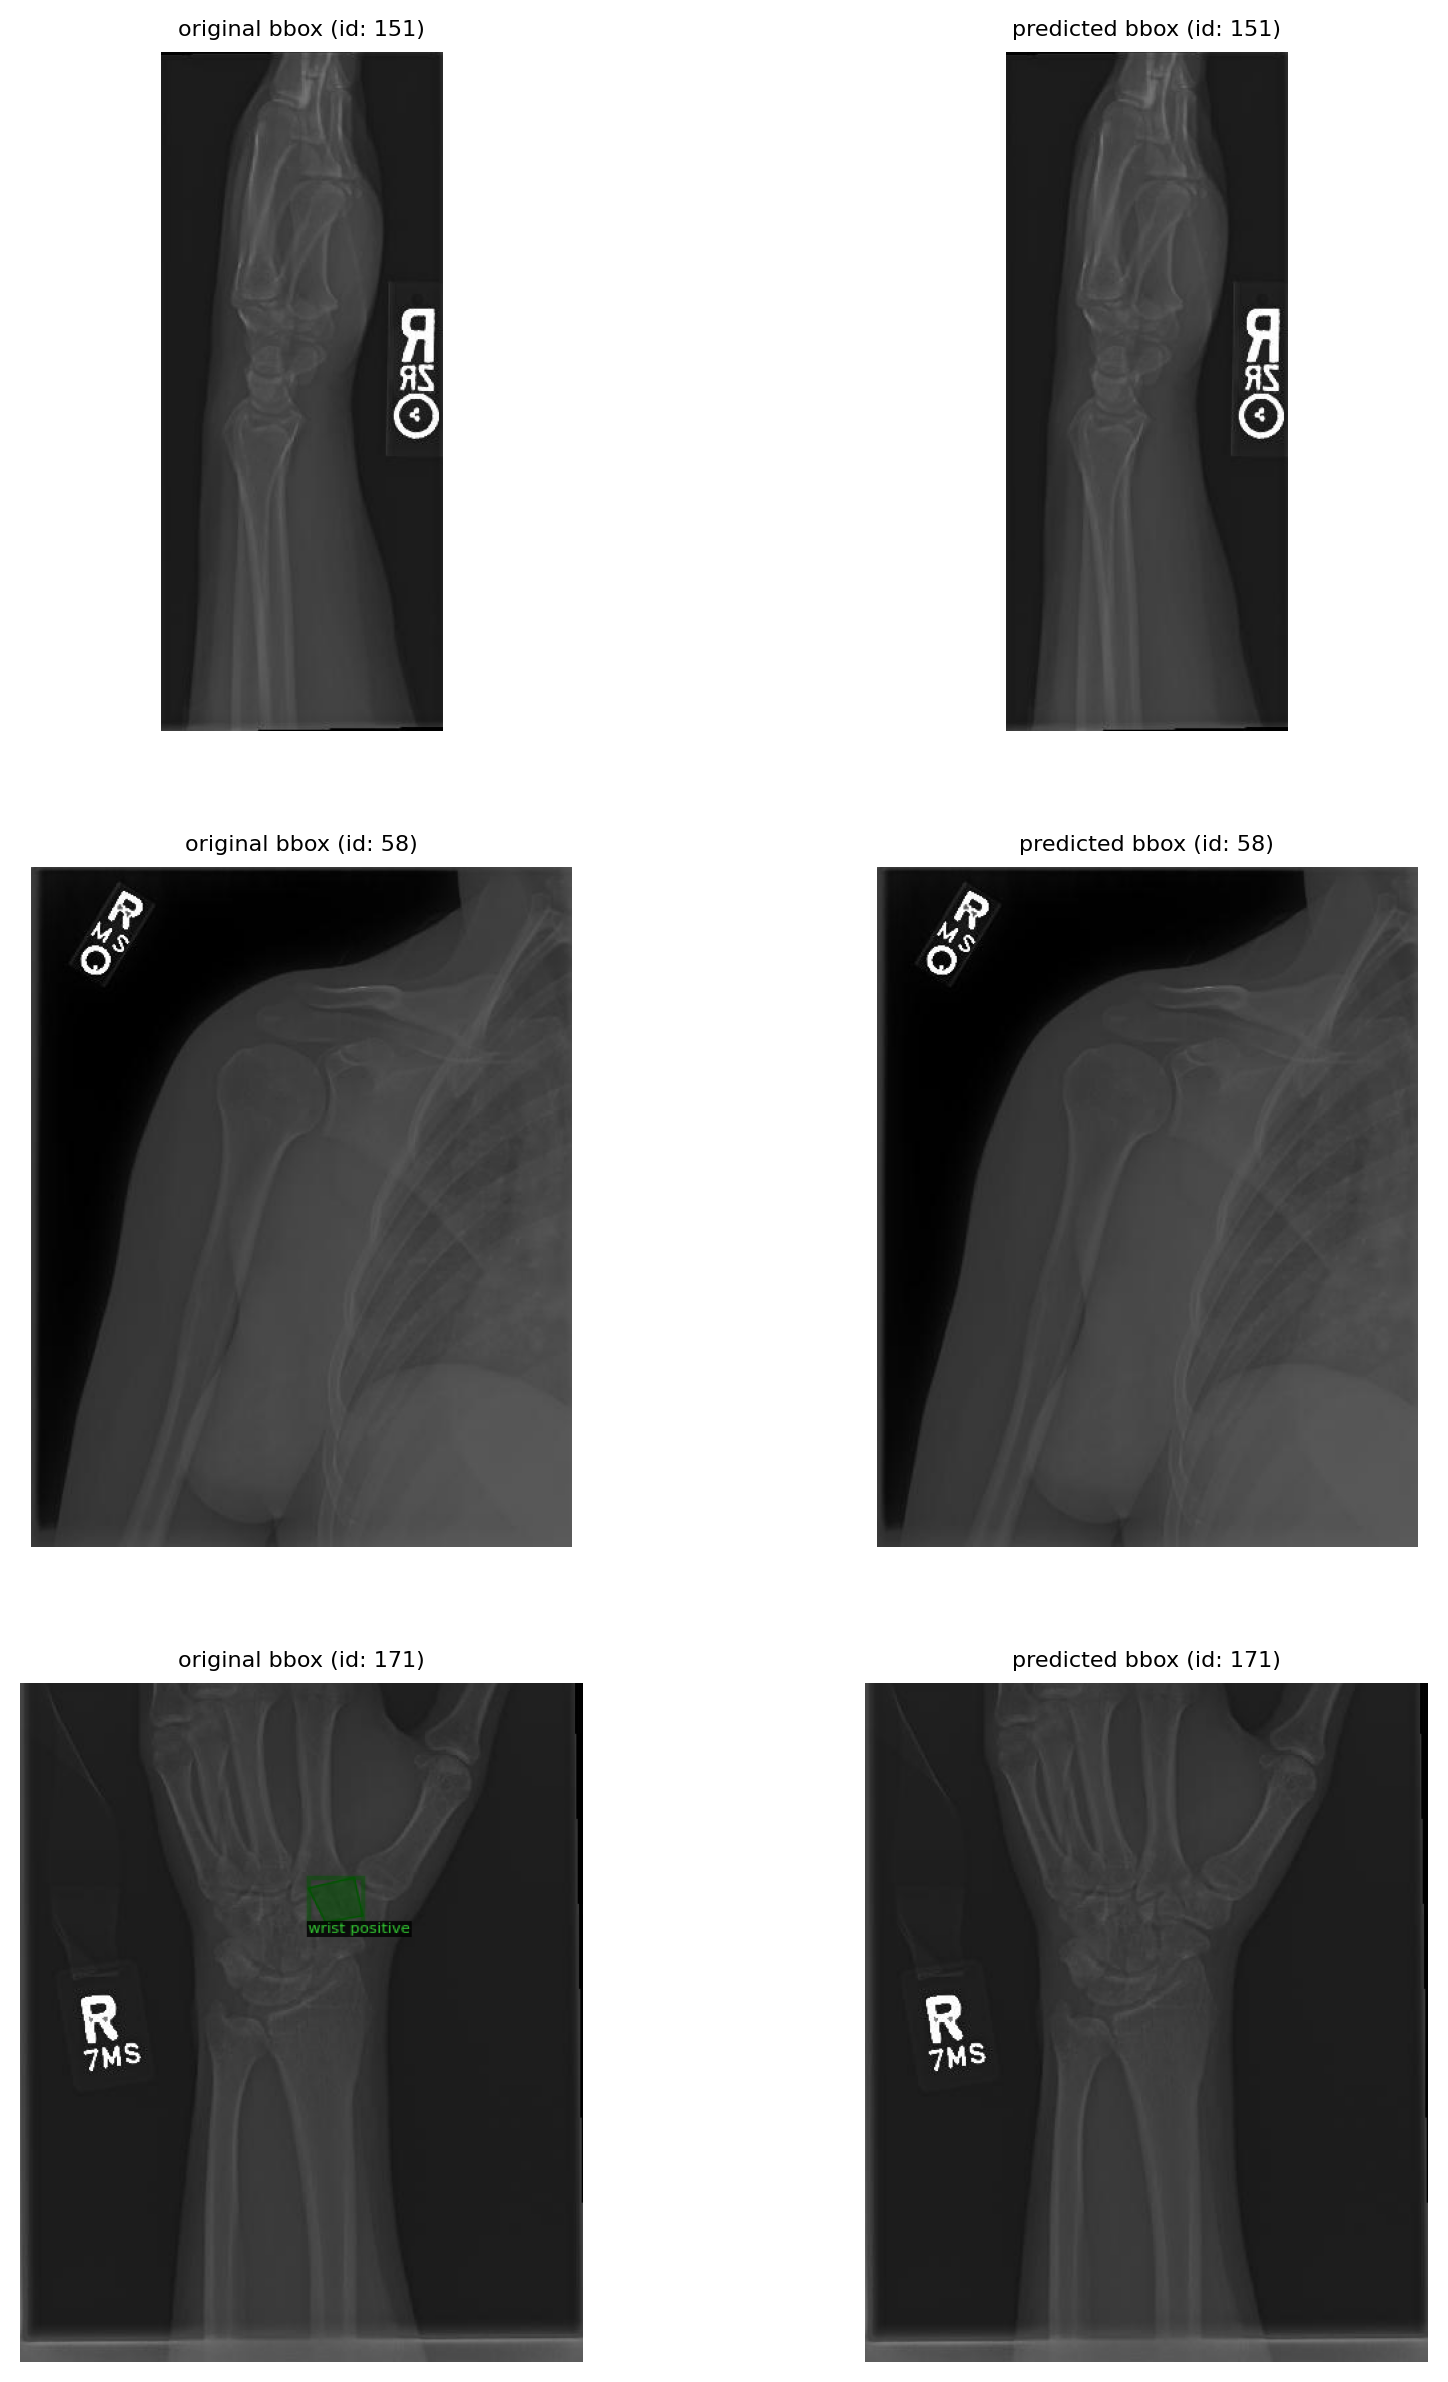

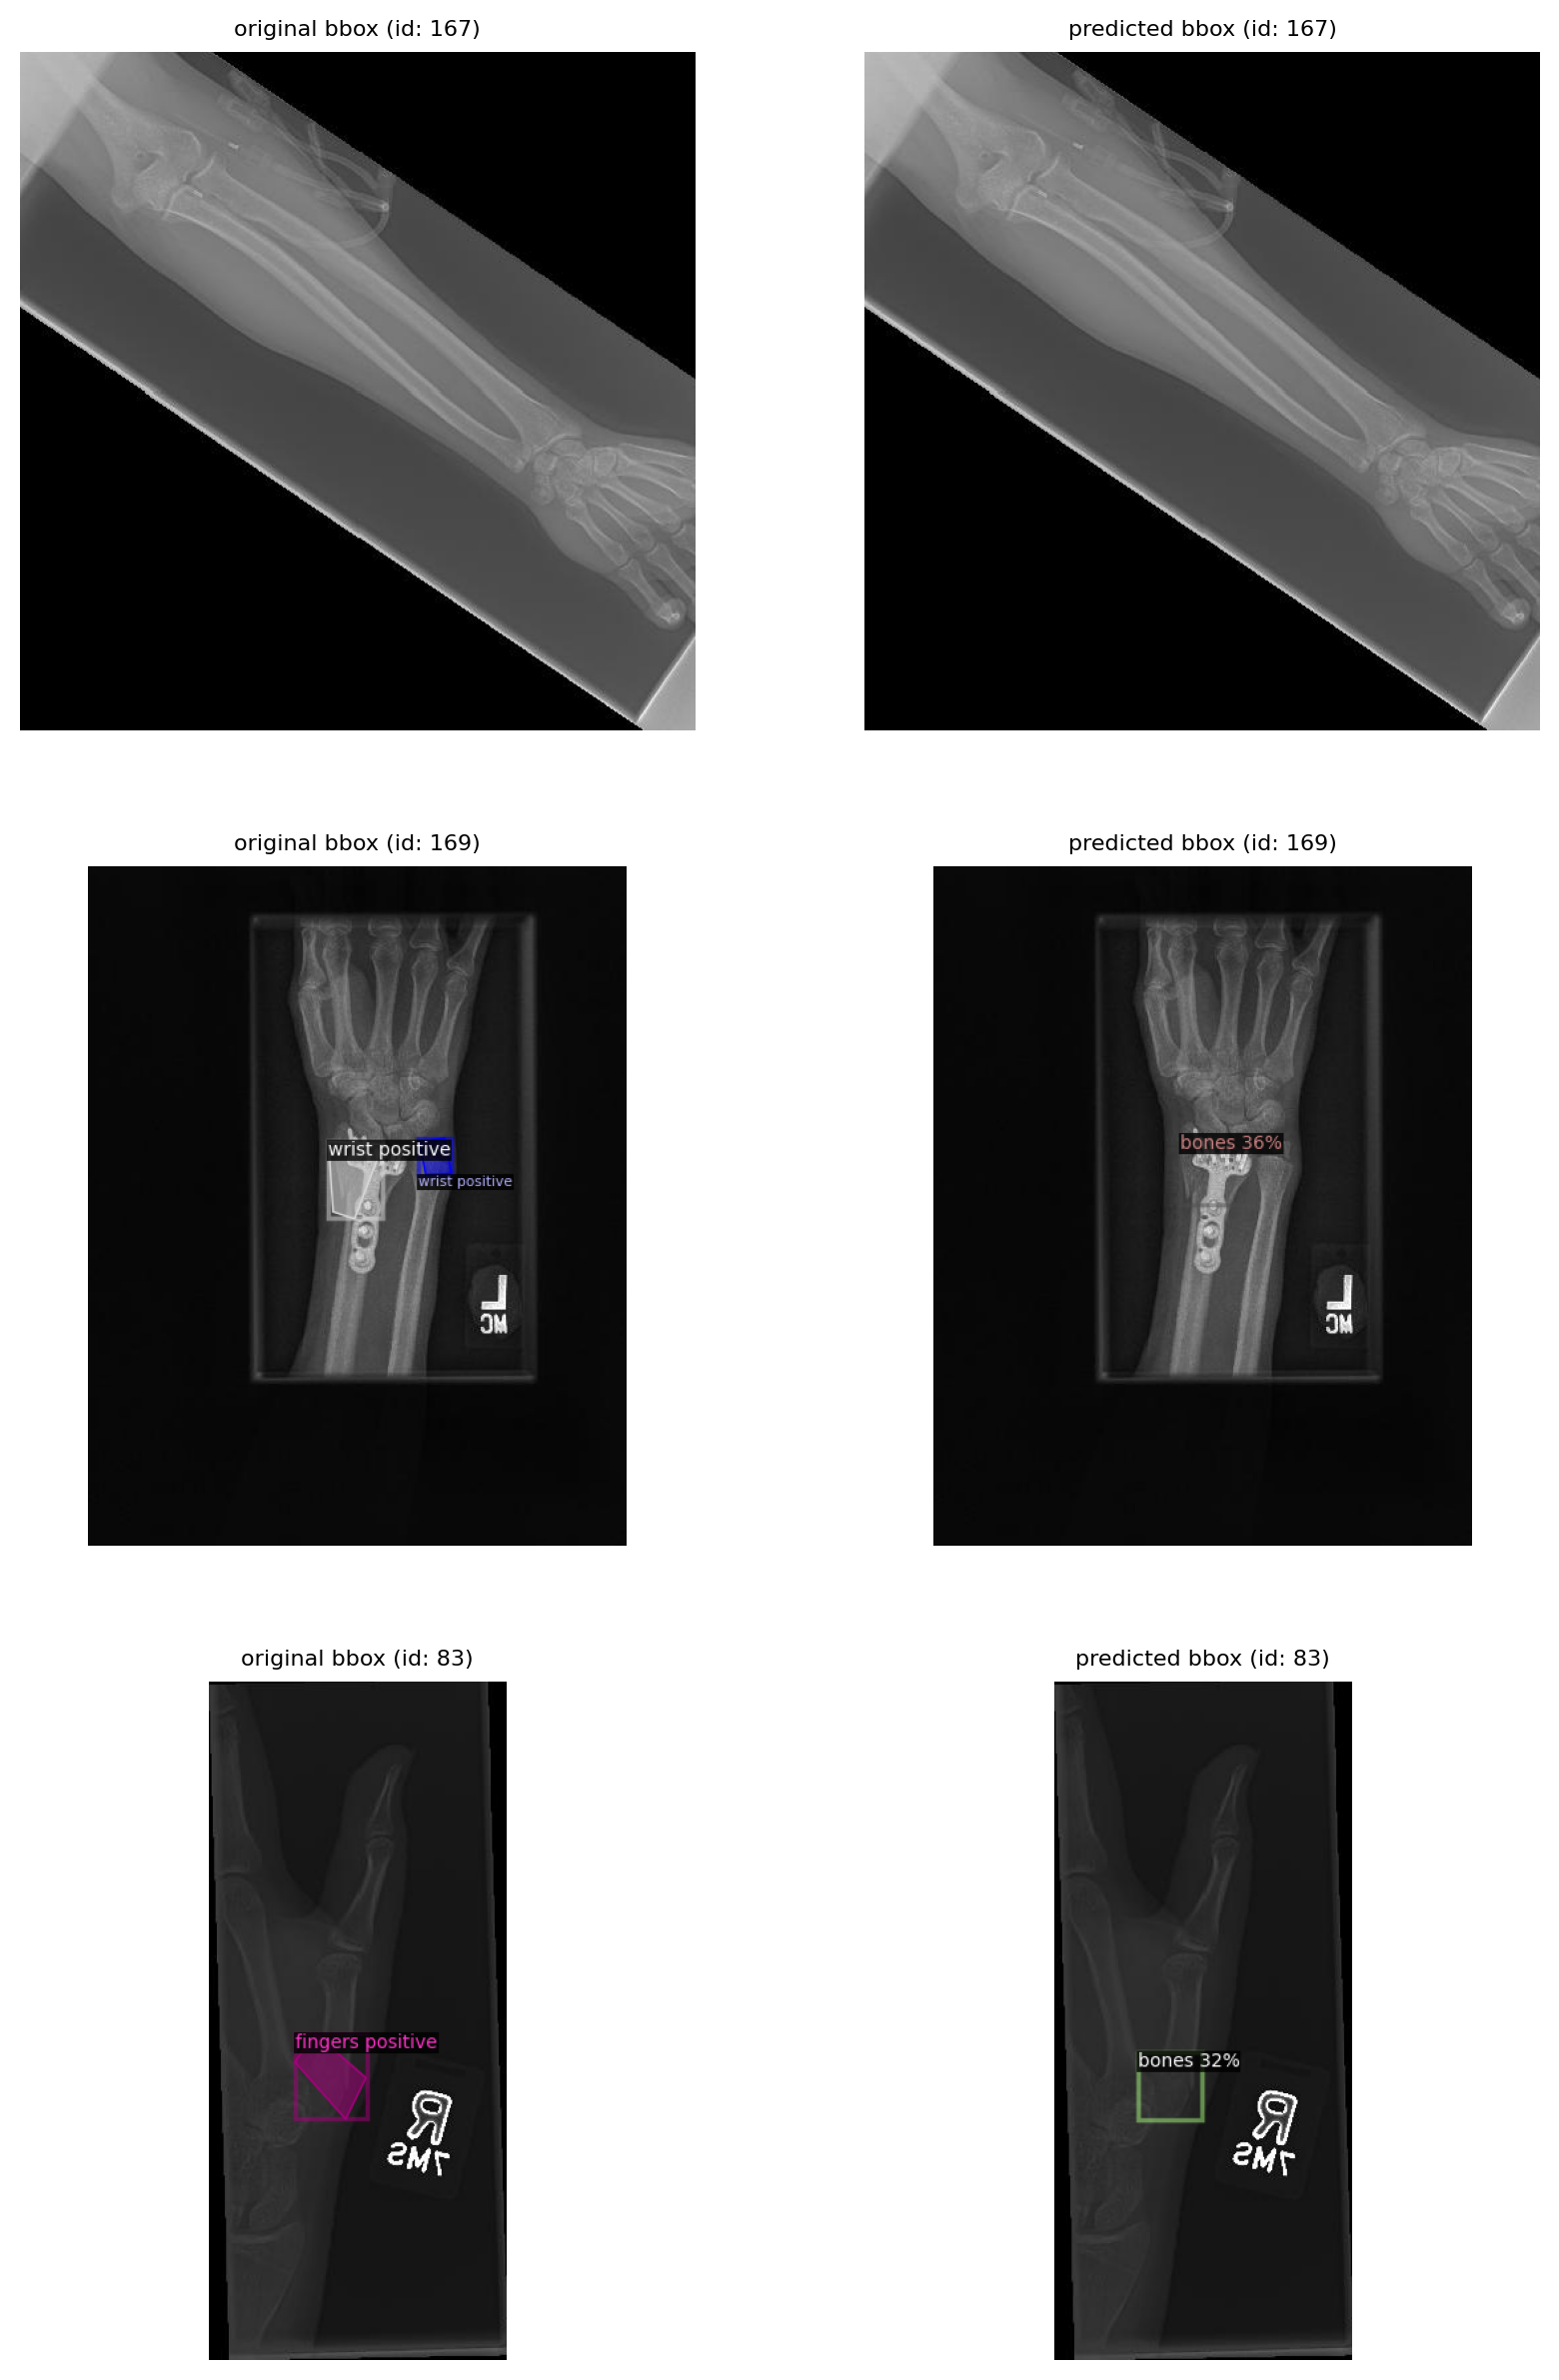

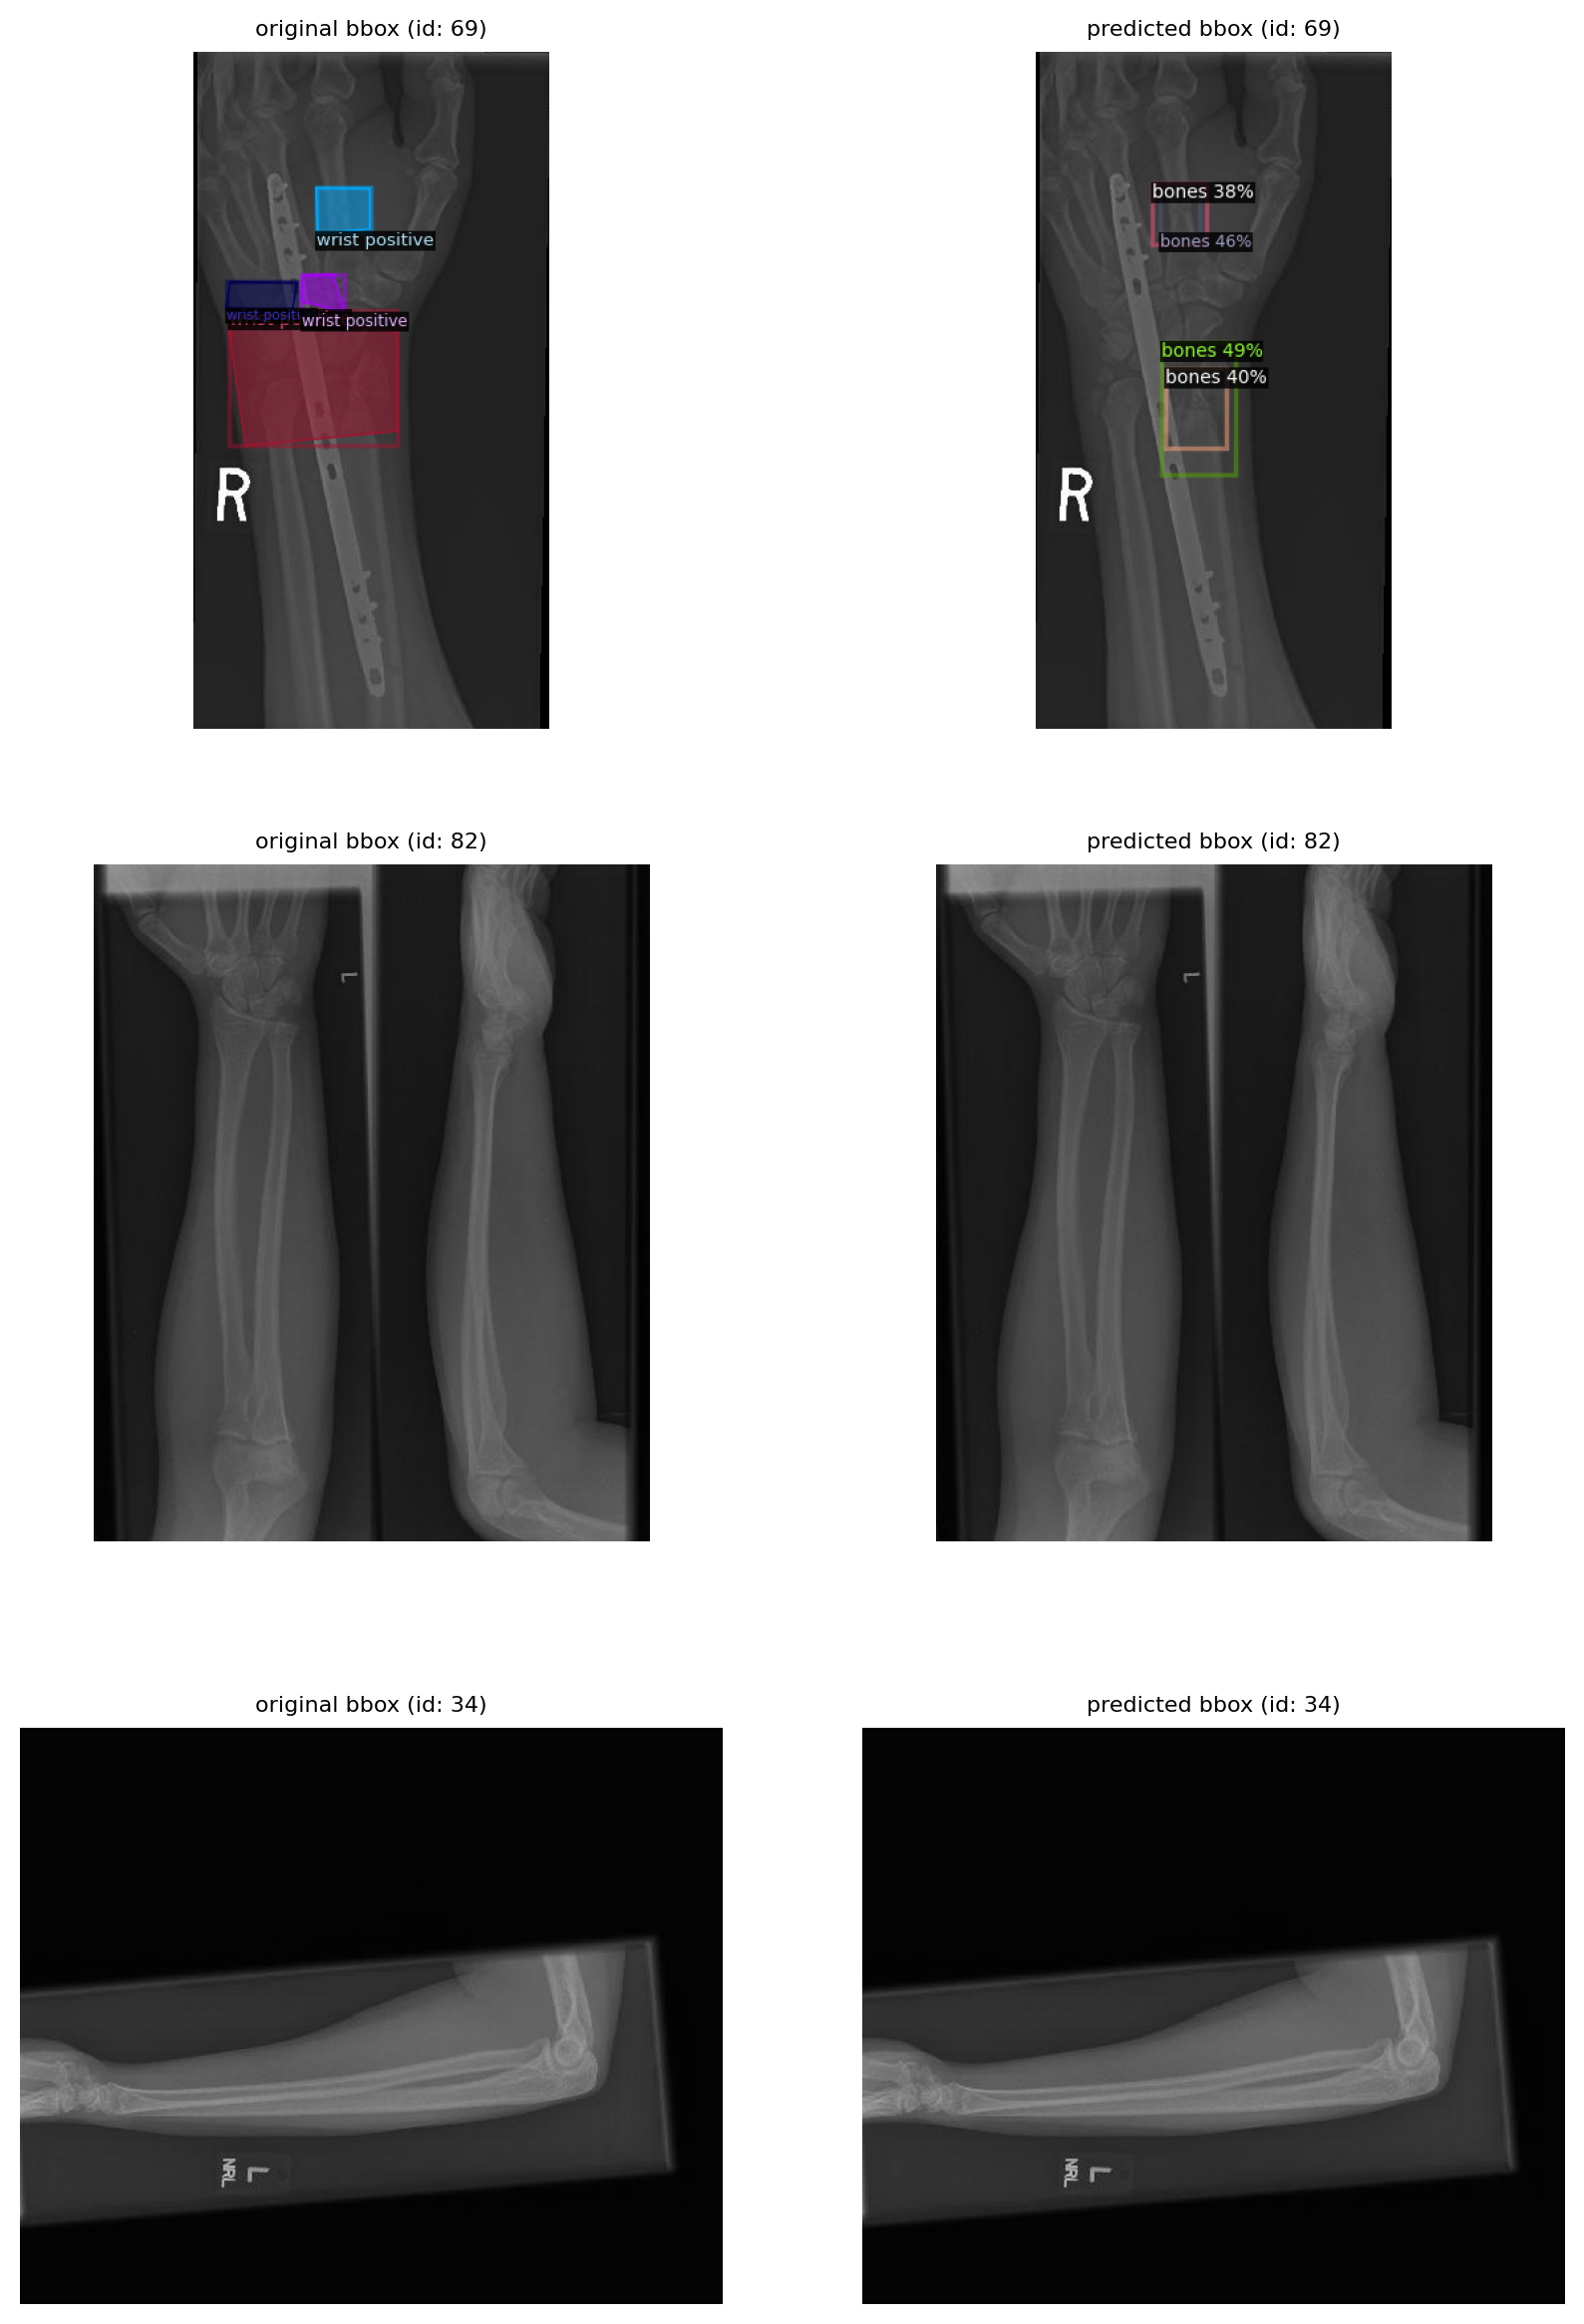

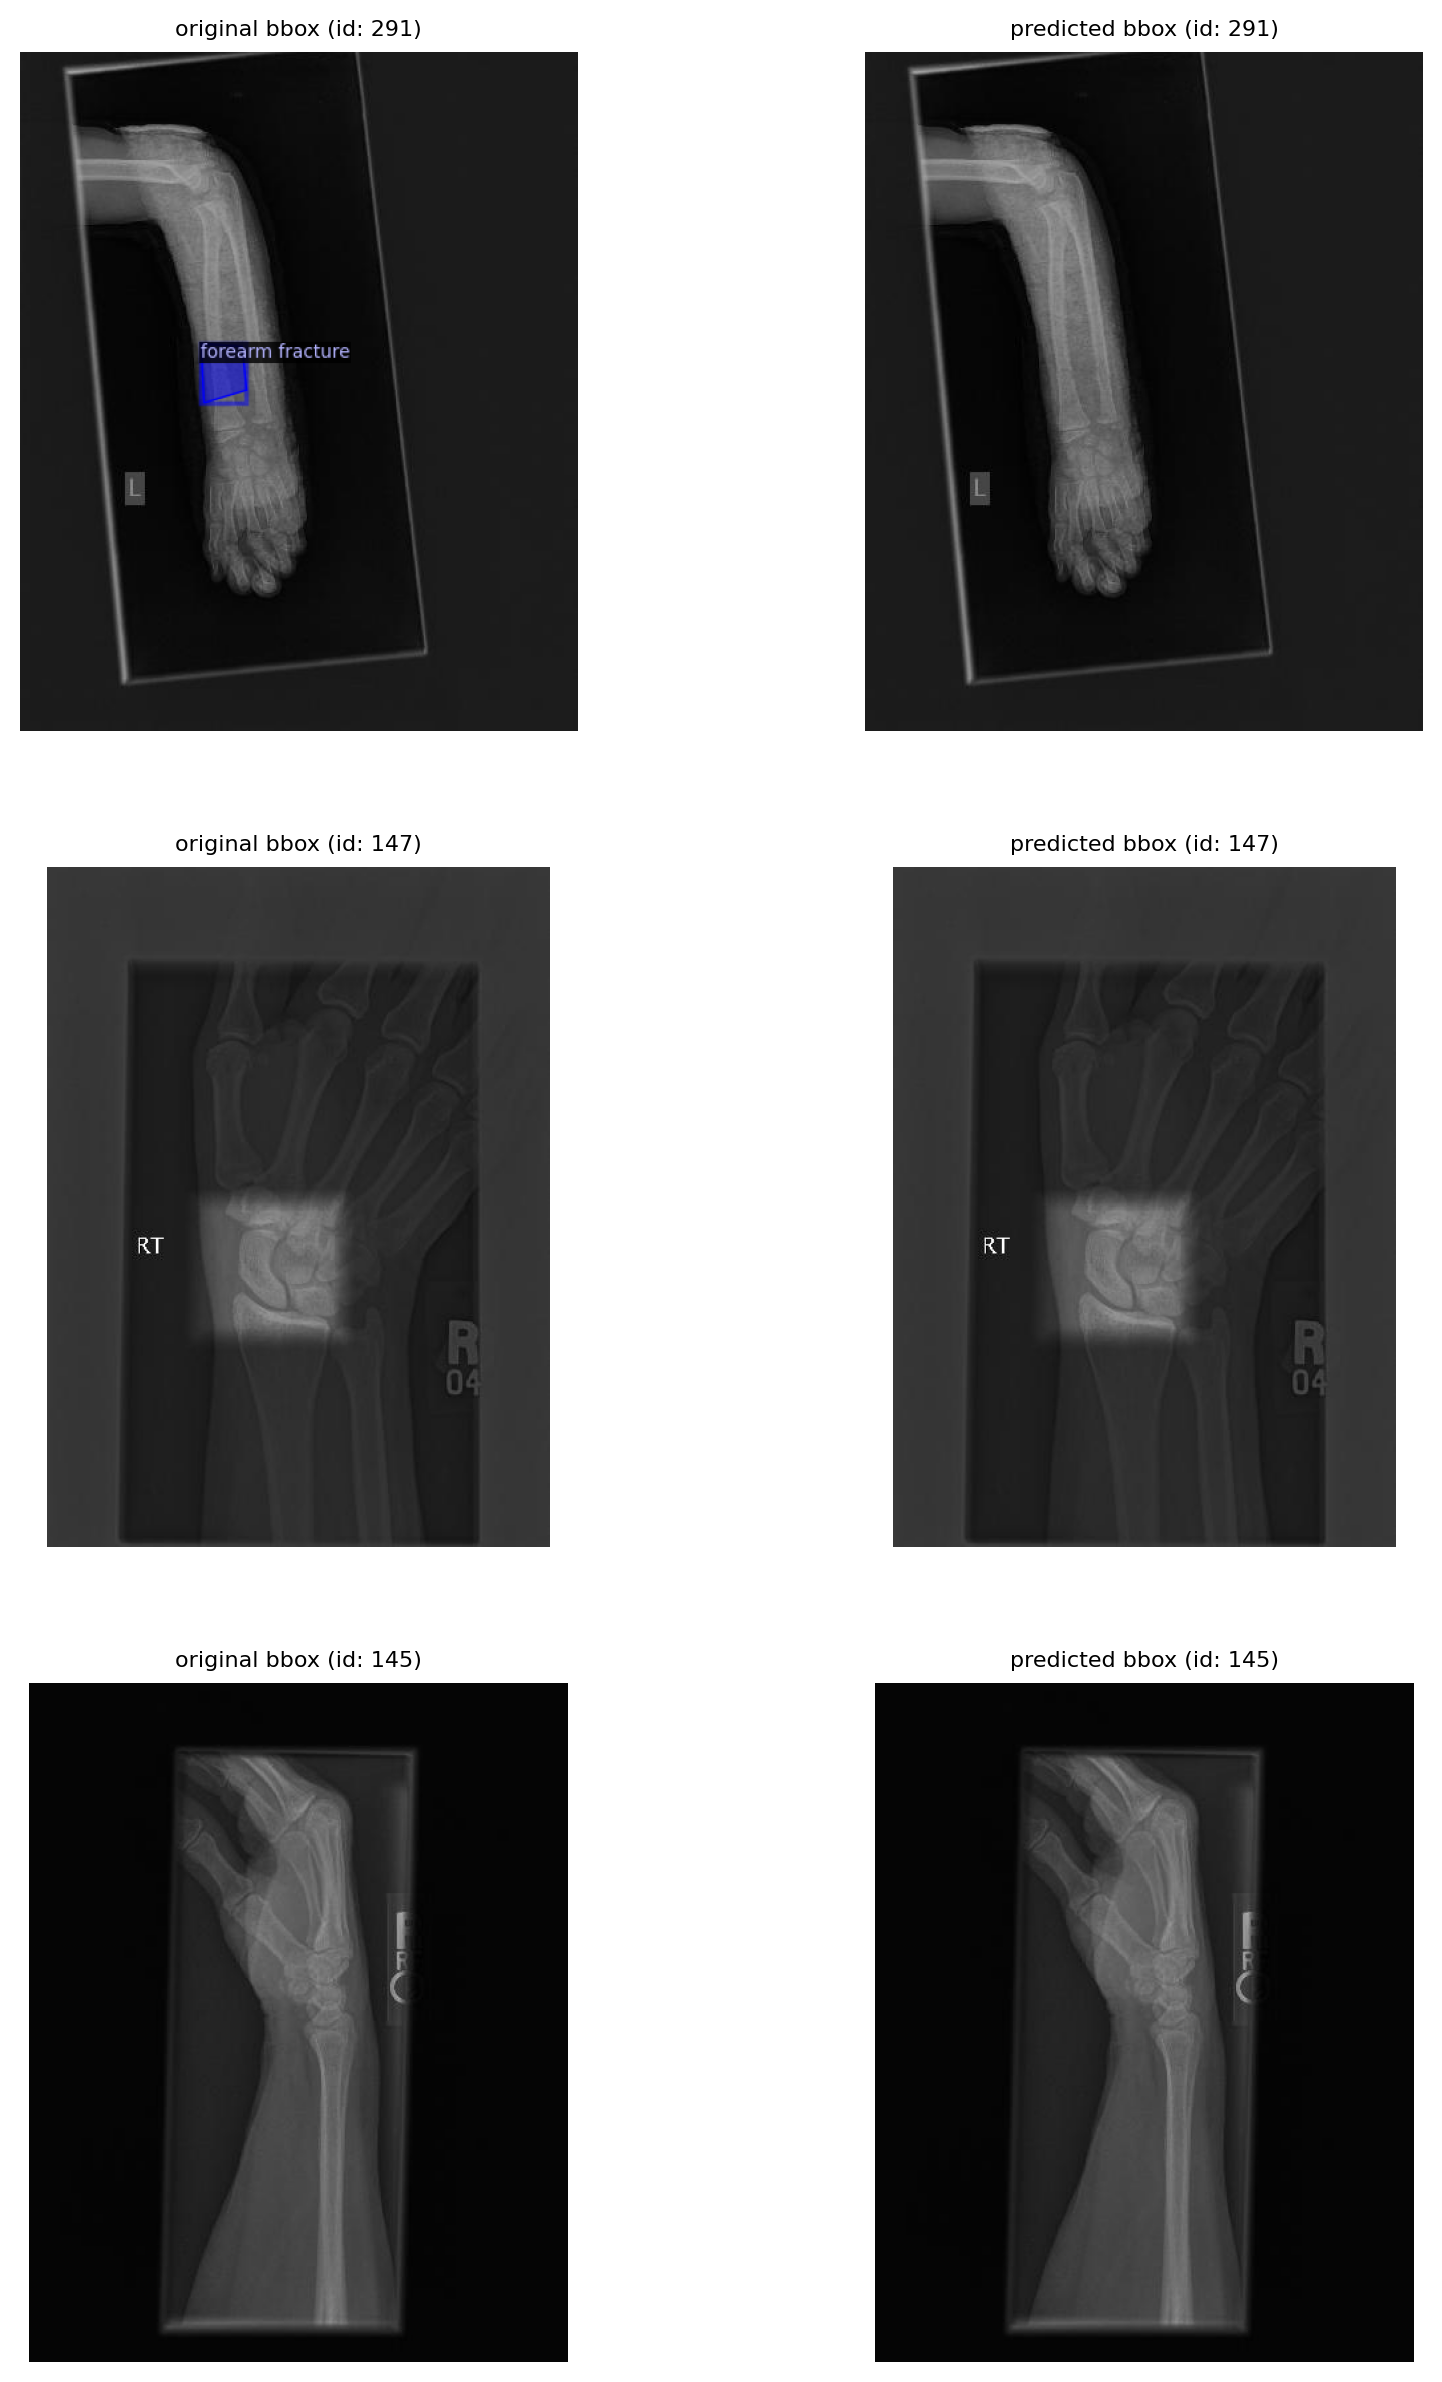

In [26]:
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 1, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 1, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 1, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 1, image_scale=1)